Mounted at /content/drive
GPU device not found. Using CPU.
Cloning into 'My-project-'...
remote: Enumerating objects: 1569, done.
remote: Counting objects: 100% (1569/1569), done.
remote: Compressing objects: 100% (1542/1542), done.
remote: Total 1569 (delta 26), reused 1564 (delta 25), pack-reused 0
Receiving objects: 100% (1569/1569), 15.82 MiB | 25.36 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Found 1260 images belonging to 2 classes.
Found 294 images belonging to 2 classes.
Epoch 1/100
40/40 [==============================] - 81s 2s/step - loss: 0.6018 - accuracy: 0.7476 - val_loss: 0.6035 - val_accuracy: 0.7143
Epoch 2/100
40/40 [==============================] - 86s 2s/step - loss: 0.5578 - accuracy: 0.7500 - val_loss: 0.4718 - val_accuracy: 0.7143
Epoch 3/100
40/40 [==============================] - 84s 2s/step - loss: 0.5303 - accuracy: 0.7500 - val_loss: 0.3688 - val_accuracy: 0.7143
Epoch 4/100
40/40 [==============================] - 78s 2s/step - loss: 0.4967 - accu

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 5s 510ms/step


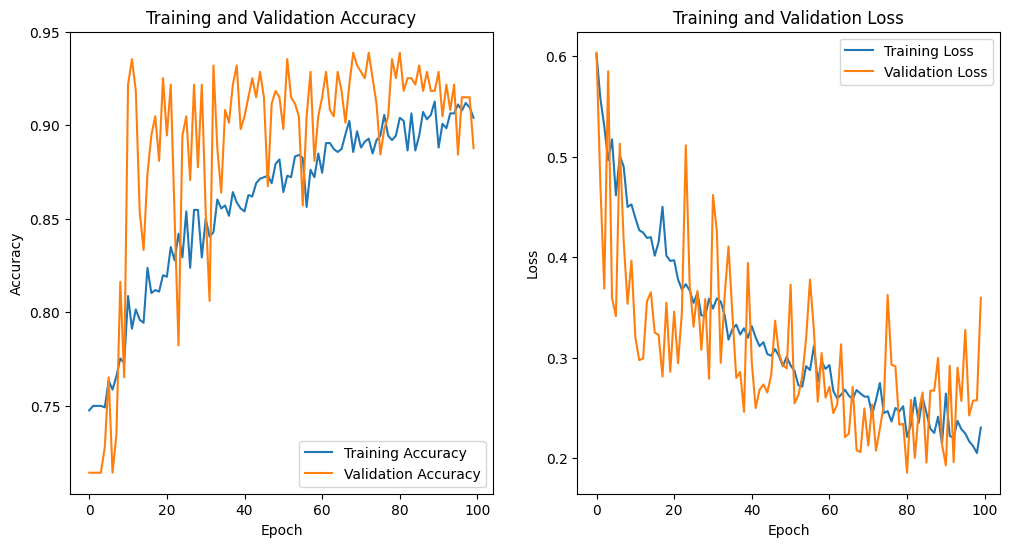

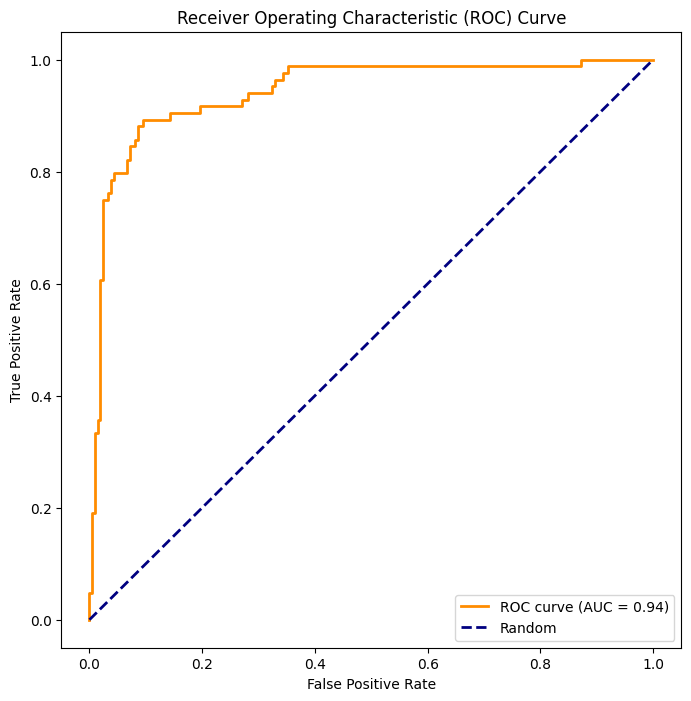

Sensitivity (Recall): 0.6667
Specificity: 0.9762
Accuracy: 0.8878


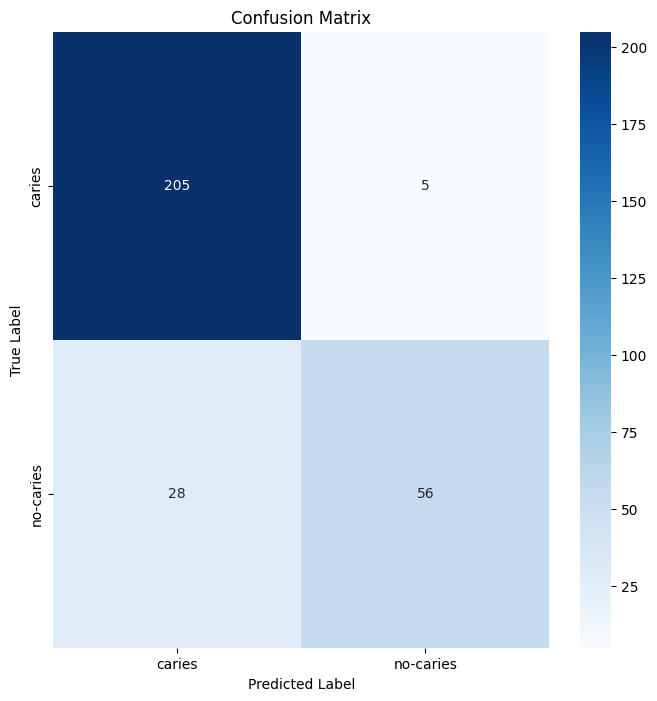

              precision    recall  f1-score   support

  non-caries       0.88      0.98      0.93       210
      caries       0.92      0.67      0.77        84

    accuracy                           0.89       294
   macro avg       0.90      0.82      0.85       294
weighted avg       0.89      0.89      0.88       294



In [ ]:
  # Necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Check if GPU available
if tf.test.gpu_device_name() == '':
    print('GPU device not found. Using CPU.')
else:
    print('GPU found. Using GPU.')

# Cloning repository of the dataset to the Colab environment
!git clone https://github.com/Pratyakshgupta887qwert/My-project-.git

# Defining deep learning model
def create_model(input_shape, num_classes):
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(150, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten layer
    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(150, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Defining input shape and number of classes
input_shape = (150, 150, 3)
num_classes = 2  # 2 classes: caries and non-caries

# Creating the model
model = create_model(input_shape, num_classes)

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Setting up data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'My-project-/test-master/train',
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',
    shuffle=True
)

validation_generator = test_datagen.flow_from_directory(
    'My-project-/test-master/test',
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

# Training the model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator
)

# Saving the model
model.save('/content/drive/MyDrive/save/dental_caries_detection.h5')

# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Display ROC curve and AUC
validation_generator.reset()
y_true = validation_generator.classes
y_pred_prob = model.predict(validation_generator)

# Predicting labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Extracting values from confusion matrix
tn, fp, fn, tp = cm.ravel()

# Sensitivity (Recall)
sensitivity = tp / (tp + fn)

# Specificity
specificity = tn / (tn + fp)

# Accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Print the metrics
print(f'Sensitivity (Recall): {sensitivity:.4f}')
print(f'Specificity: {specificity:.4f}')
print(f'Accuracy: {accuracy:.4f}')

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_generator.class_indices,
            yticklabels=train_generator.class_indices)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Display classification report
class_labels = ['non-caries', 'caries']
print(classification_report(y_true, y_pred, target_names=class_labels))
